### DLP Lab2
#### Requirment
1. Implement **EEGNet**, **DeepConvNet** with three kinds of activation function including **ReLU**, **Leaky ReLU**, **ELU**
2. Print accuracy of each epochs at training set and test set
3. Show the highest accuracy

#### Hyper parameters
Batch size= 64 Learning rate = 1e-2 Epochs = 300
Optimizer: Adam Loss function: torch.nn.CrossEntropyLoss()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from dataloader import read_bci_data

#### Data
Input: \[B, 1, 2, 750\] Output: \[B, 2\] Ground truth: \[B\]

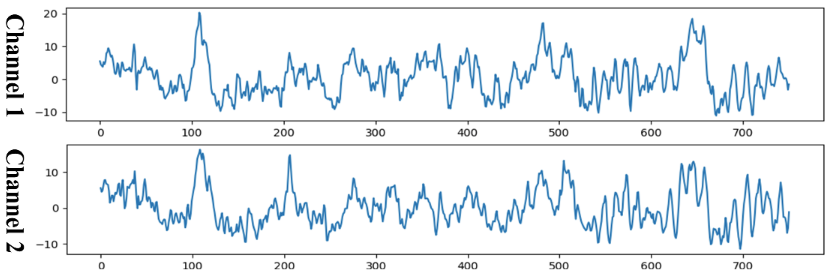

In [2]:
train_data, train_label, test_data, test_label = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [5]:
# init trainset
train_data_tensors = torch.tensor(train_data, device=device)
train_label_tensors = torch.tensor(train_label, dtype=torch.long, device=device)
trainset = TensorDataset(train_data_tensors, train_label_tensors)

# init testset
test_data_tensors = torch.tensor(test_data, device=device)
test_label_tensors = torch.tensor(test_label, dtype=torch.long, device=device)
testset = TensorDataset(test_data_tensors, test_label_tensors)

#### Activation

In [8]:
nn.LeakyReLU()
nn.ReLU()
nn.ELU()

ELU(alpha=1.0)

#### Predict

In [6]:
# predict and calculate accuracy
def get_predict(model, loader):
    predictions = None
    total = 0
    correct = 0
    
    with torch.no_grad():
        for data, label in loader:
            # forward pass
            output = model.forward(data)
            output = nn.Softmax(dim=1)(output)
            
            # get output label
            _, pred = torch.max(output, 1)

            total += label.shape[0]
            correct += (pred == label).sum().item()
            
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
                
    acc = correct / total
            
    return predictions, acc

#### Result

In [82]:
def show_one_result(accuracy, model):            
    label = ["train", "test"]
    
    plt.figure(figsize=(8,4))
    
    plt.xlabel("Accuracy(%)")
    plt.ylabel("Epochs")
    plt.title("Activation function comparison("+model+")", fontsize=18)
    
    for idx, acc in enumerate(accuracy):
        plt.plot(acc, label=label[idx])
    
    plt.legend()
    plt.show()

In [165]:
def show_result(accuracy, model):            
    label = ["train_relu", "train_leakyrelu", "train_elu", "test_relu", "test_leakyrelu", "test_elu"]
    
    plt.figure(figsize=(10,6))
    
    plt.ylabel("Accuracy(%)")
    plt.xlabel("Epochs")
    plt.title("Activation function comparison("+model+")", fontsize=18)
    
    for idx, acc in enumerate(accuracy):
        plt.plot(acc, label=label[idx])
    
    plt.legend()
    plt.show()

### EEGNet

In [127]:
class EGGModel(nn.Module):
    def __init__(self, activation_function="relu"):
        # choose activation
        assert activation_function == "relu" or activation_function == "elu" or activation_function == "leakyrelu"
        self.activation = activation_function
        activation_dict = {"relu": nn.ReLU(), 
                           "elu": nn.ELU(alpha=1.0), 
                           "leakyrelu": nn.LeakyReLU(negative_slope=0.01)
                          }
        
        # init conv
        super(EGGModel, self).__init__()
        self.firstConv = nn.Sequential(
                            nn.Conv2d(1,16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
                            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                        )
        self.depthwiseConv = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
                                nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                activation_dict[activation_function],
                                nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
                                nn.Dropout(p=0.25)
                            )
        self.separableConv = nn.Sequential(
                                nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
                                nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                activation_dict[activation_function],
                                nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
                                nn.Dropout(p=0.25)
                            )
        self.classify = nn.Sequential(
                            nn.Linear(in_features=736, out_features=2, bias=True)
                        )


    def forward(self, x):
        x = self.firstConv(x) 
        x = self.depthwiseConv(x) 
        x = self.separableConv(x) 
        x = x.view(x.size(0), -1) # flatten x, [B, 32, 1, 23] => [B, 736] 
        x = self.classify(x) 
        return x
    
    def train(self, batch_size=64, epochs=300, lr=0.001):
        batch_size = batch_size
        epochs = epochs
        lr = lr
        
        # creare dataloaders
        trainloader = DataLoader(trainset, batch_size=batch_size)
        testloader = DataLoader(testset, batch_size=batch_size)
        
        # set optimizer, loss function
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # record loss and train accuracy
        train_acc = []
        test_acc = []

        for epoch in range(epochs):
            running_loss = 0.0

            for data, label in trainloader:
                # set parameter gradient into zero
                optimizer.zero_grad()

                # forward pass
                output = self.forward(data)

                # backward
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()

                # record the loss
                running_loss += loss.item()

            # record accuracy for each epochs
            _, train = get_predict(self, trainloader)
            train_acc.append(train)
            _, test = get_predict(self, testloader)
            test_acc.append(test)
            
            # print accuracy every 10 epochs
            if epoch % 10 == 0:
                print ("Epoch: %s, train accuracy: %s, test accuract: %s"%(epoch, train, test))
        
        # test 
        print ("Accuracy of EEG model with %s: %10s"%(self.activation, test_acc[-1]))
        
        return train_acc, test_acc

In [11]:
eegmodel = EGGModel(activation_function="relu")
print(eegmodel) 

EGGModel(
  (firstConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)


#### EEG ReLU

Epoch: 0, train accuracy: 0.6768518518518518, test accuract: 0.6675925925925926
Epoch: 10, train accuracy: 0.8111111111111111, test accuract: 0.7388888888888889
Epoch: 20, train accuracy: 0.8703703703703703, test accuract: 0.7777777777777778
Epoch: 30, train accuracy: 0.912962962962963, test accuract: 0.7861111111111111
Epoch: 40, train accuracy: 0.9166666666666666, test accuract: 0.7870370370370371
Epoch: 50, train accuracy: 0.9462962962962963, test accuract: 0.8064814814814815
Epoch: 60, train accuracy: 0.9472222222222222, test accuract: 0.8046296296296296
Epoch: 70, train accuracy: 0.9574074074074074, test accuract: 0.7953703703703704
Epoch: 80, train accuracy: 0.9490740740740741, test accuract: 0.8027777777777778
Epoch: 90, train accuracy: 0.9629629629629629, test accuract: 0.812037037037037
Epoch: 100, train accuracy: 0.9805555555555555, test accuract: 0.7981481481481482
Epoch: 110, train accuracy: 0.95, test accuract: 0.8111111111111111
Epoch: 120, train accuracy: 0.9787037037037

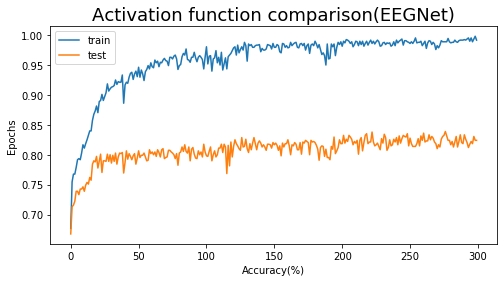

In [116]:
# model init
eegmodel = EGGModel(activation_function="relu")
eegmodel = eegmodel.to(device)
eegmodel.double()
eeg_relu_train_acc, eeg_relu_test_acc = eegmodel.train(batch_size=64, epochs=300, lr=0.001)

# show train and test result
show_one_result([eeg_relu_train_acc, eeg_relu_test_acc], model="EEGNet")

#### EEG Leaky ReLU

Epoch: 0, train accuracy: 0.7277777777777777, test accuract: 0.7157407407407408
Epoch: 10, train accuracy: 0.8537037037037037, test accuract: 0.7935185185185185
Epoch: 20, train accuracy: 0.887962962962963, test accuract: 0.8212962962962963
Epoch: 30, train accuracy: 0.9212962962962963, test accuract: 0.8314814814814815
Epoch: 40, train accuracy: 0.9407407407407408, test accuract: 0.8361111111111111
Epoch: 50, train accuracy: 0.950925925925926, test accuract: 0.8305555555555556
Epoch: 60, train accuracy: 0.9583333333333334, test accuract: 0.8361111111111111
Epoch: 70, train accuracy: 0.9592592592592593, test accuract: 0.8342592592592593
Epoch: 80, train accuracy: 0.9685185185185186, test accuract: 0.8194444444444444
Epoch: 90, train accuracy: 0.9712962962962963, test accuract: 0.8314814814814815
Epoch: 100, train accuracy: 0.9768518518518519, test accuract: 0.8472222222222222
Epoch: 110, train accuracy: 0.9814814814814815, test accuract: 0.85
Epoch: 120, train accuracy: 0.9796296296296

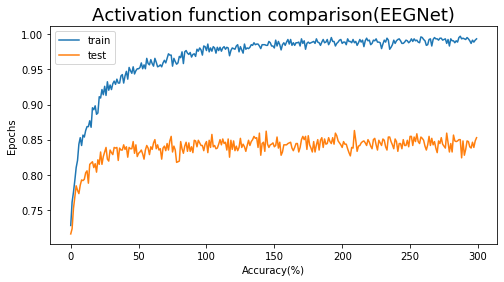

In [163]:
# model init
eegmodel = EGGModel(activation_function="leakyrelu")
eegmodel = eegmodel.to(device)
eegmodel.double()
eeg_leakyrelu_train_acc, eeg_leakyrelu_test_acc = eegmodel.train(batch_size=12, epochs=300, lr=0.0004)

# show train and test result
show_one_result([eeg_leakyrelu_train_acc, eeg_leakyrelu_test_acc], model="EEGNet")

#### EEG ELU

Epoch: 0, train accuracy: 0.7518518518518519, test accuract: 0.7138888888888889
Epoch: 10, train accuracy: 0.8305555555555556, test accuract: 0.7620370370370371
Epoch: 20, train accuracy: 0.8796296296296297, test accuract: 0.7833333333333333
Epoch: 30, train accuracy: 0.9, test accuract: 0.799074074074074
Epoch: 40, train accuracy: 0.9212962962962963, test accuract: 0.7962962962962963
Epoch: 50, train accuracy: 0.925, test accuract: 0.7907407407407407
Epoch: 60, train accuracy: 0.9314814814814815, test accuract: 0.8111111111111111
Epoch: 70, train accuracy: 0.95, test accuract: 0.8212962962962963
Epoch: 80, train accuracy: 0.9592592592592593, test accuract: 0.8046296296296296
Epoch: 90, train accuracy: 0.9611111111111111, test accuract: 0.8222222222222222
Epoch: 100, train accuracy: 0.9787037037037037, test accuract: 0.8212962962962963
Epoch: 110, train accuracy: 0.975, test accuract: 0.8138888888888889
Epoch: 120, train accuracy: 0.9703703703703703, test accuract: 0.8046296296296296
E

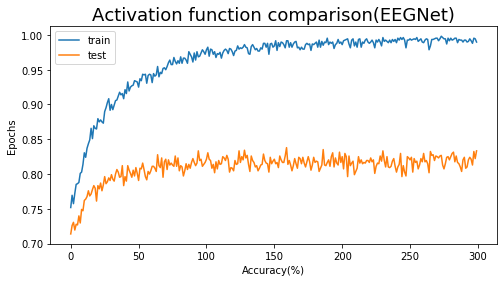

In [135]:
# model init
eegmodel = EGGModel(activation_function="elu")
eegmodel = eegmodel.to(device)
eegmodel.double()
eeg_elu_train_acc, eeg_elu_test_acc = eegmodel.train(batch_size=12, epochs=300, lr=0.0005)

# show train and test result
show_one_result([eeg_elu_train_acc, eeg_elu_test_acc], model="EEGNet")

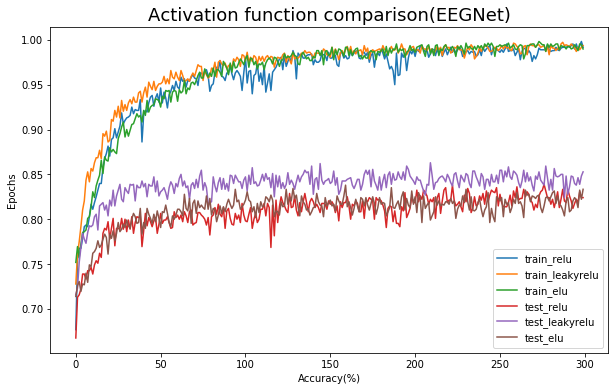

In [164]:
# show train and test result
accuracy = [eeg_relu_train_acc, eeg_leakyrelu_train_acc, eeg_elu_train_acc, 
            eeg_relu_test_acc, eeg_leakyrelu_test_acc, eeg_elu_test_acc]
show_result(accuracy, model="EEGNet")

#### Brute force for finding hyperparameters
Use same way on other models, only remain this cell as a example, and delete others for maintaining a pretty note. ouo

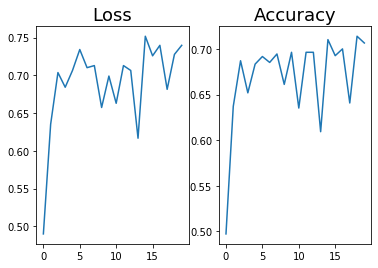

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  200, lr is    0.1: 0.7046296296296296


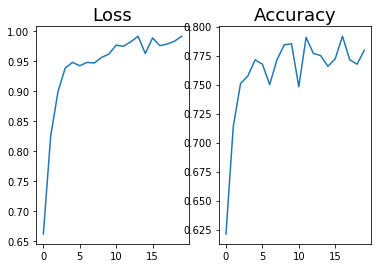

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  200, lr is   0.01: 0.7851851851851852


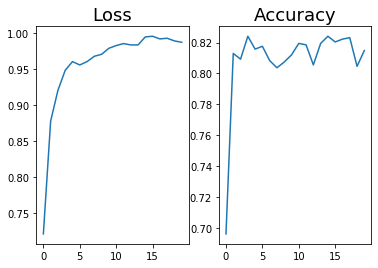

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  200, lr is  0.001: 0.8111111111111111


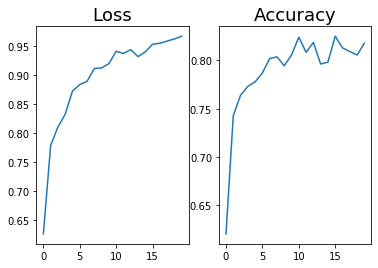

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  200, lr is 0.0001: 0.8074074074074075


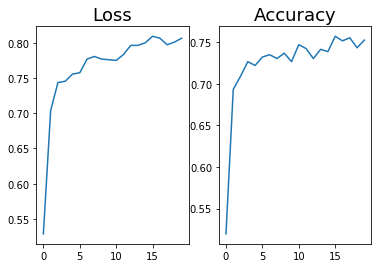

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  200, lr is  1e-05: 0.7444444444444445


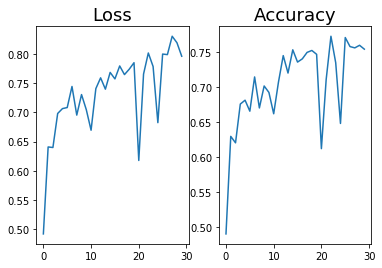

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  300, lr is    0.1: 0.7574074074074074


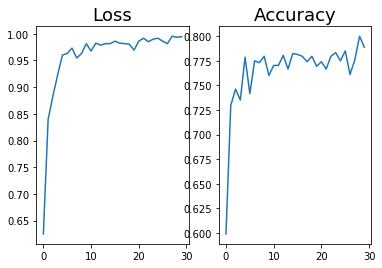

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  300, lr is   0.01: 0.7666666666666667


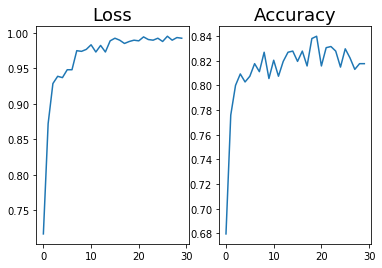

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  300, lr is  0.001: 0.8324074074074074


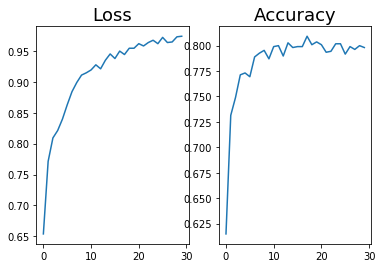

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  300, lr is 0.0001: 0.8055555555555556


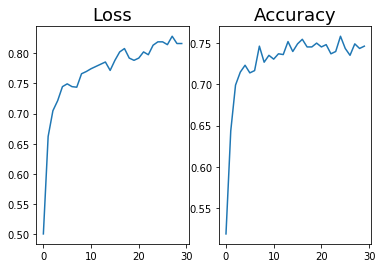

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  300, lr is  1e-05: 0.7546296296296297


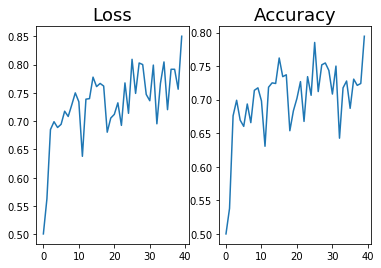

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  400, lr is    0.1: 0.7768518518518519


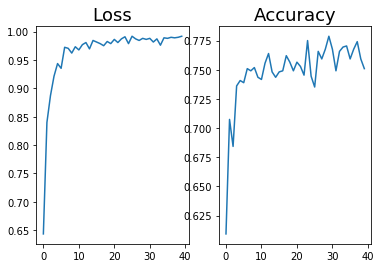

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  400, lr is   0.01: 0.7472222222222222


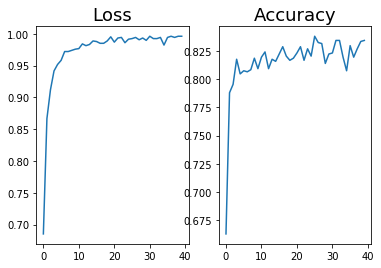

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  400, lr is  0.001: 0.8203703703703704


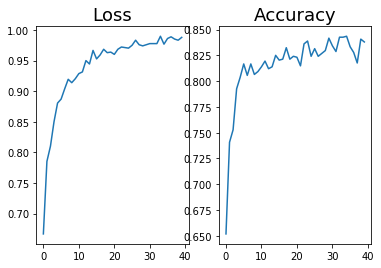

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  400, lr is 0.0001: 0.8453703703703703


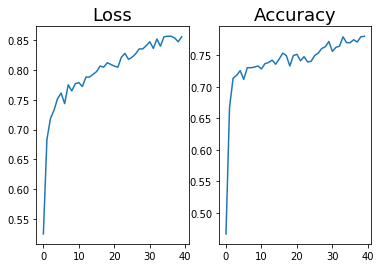

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  400, lr is  1e-05: 0.7759259259259259


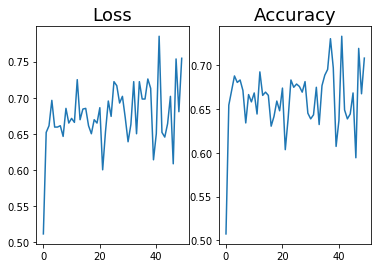

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  500, lr is    0.1: 0.6620370370370371


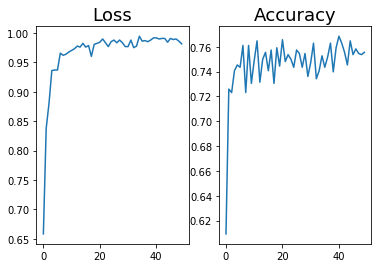

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  500, lr is   0.01: 0.7666666666666667


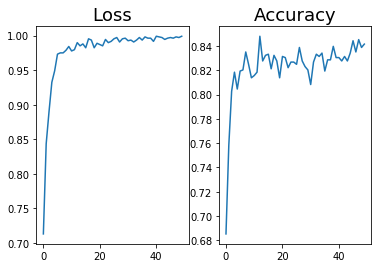

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  500, lr is  0.001: 0.8425925925925926


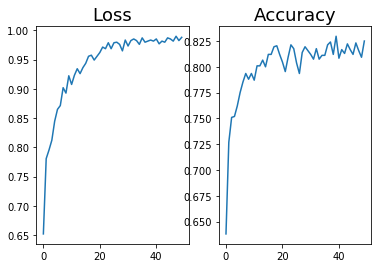

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  500, lr is 0.0001: 0.8203703703703704


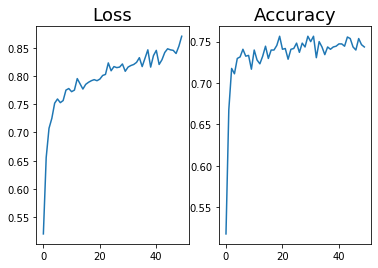

Accuracy of EEG model with  leakyrelu, batch size is   12, epochs is  500, lr is  1e-05: 0.7518518518518519


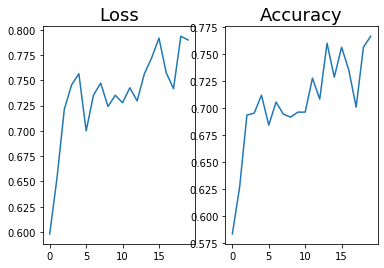

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  200, lr is    0.1: 0.7462962962962963


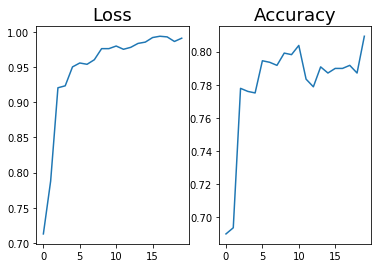

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  200, lr is   0.01: 0.7851851851851852


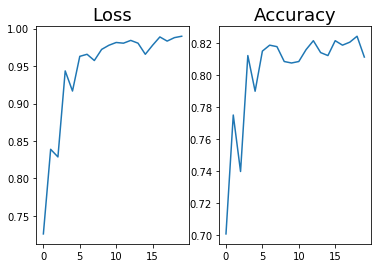

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  200, lr is  0.001: 0.8157407407407408


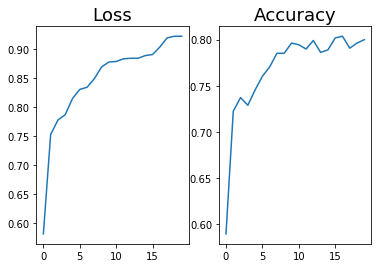

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  200, lr is 0.0001: 0.7907407407407407


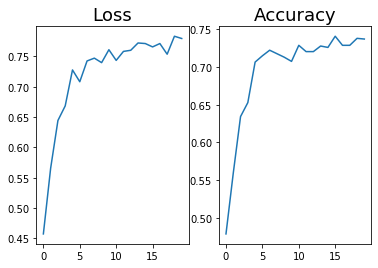

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  200, lr is  1e-05: 0.7333333333333333


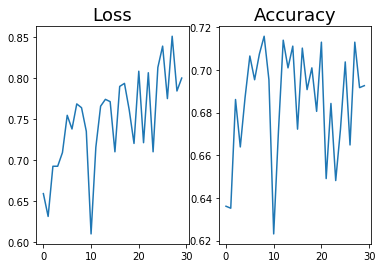

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  300, lr is    0.1: 0.6583333333333333


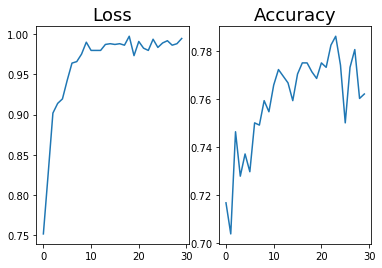

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  300, lr is   0.01: 0.7574074074074074


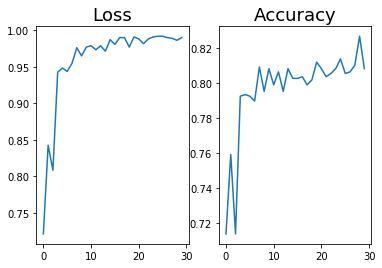

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  300, lr is  0.001: 0.8175925925925925


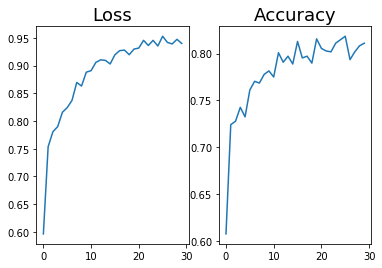

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  300, lr is 0.0001: 0.7953703703703704


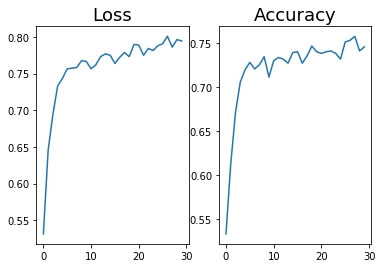

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  300, lr is  1e-05: 0.7537037037037037


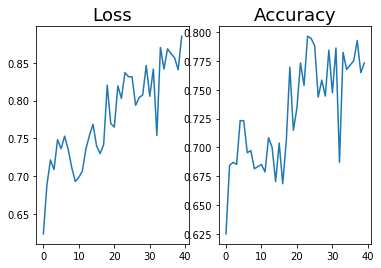

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  400, lr is    0.1: 0.7685185185185185


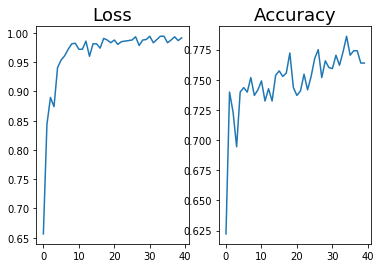

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  400, lr is   0.01: 0.7611111111111111


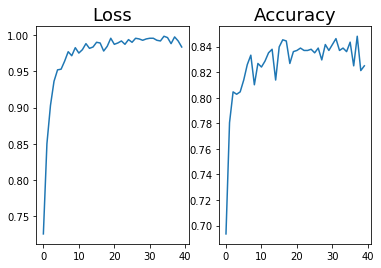

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  400, lr is  0.001: 0.8398148148148148


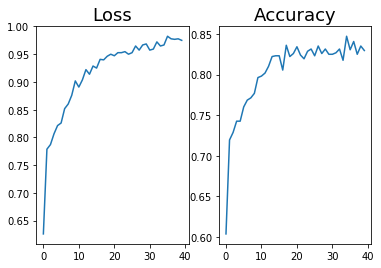

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  400, lr is 0.0001: 0.8287037037037037


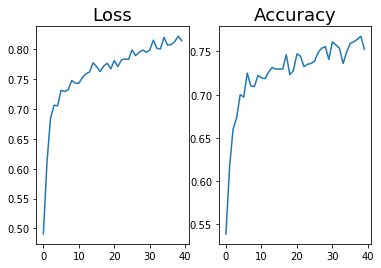

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  400, lr is  1e-05: 0.7685185185185185


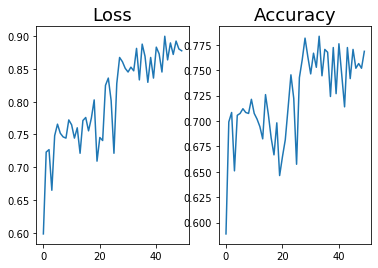

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  500, lr is    0.1: 0.7824074074074074


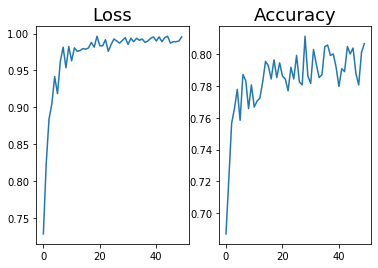

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  500, lr is   0.01: 0.7944444444444444


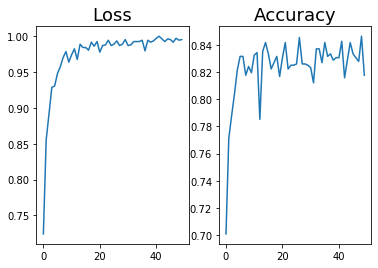

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  500, lr is  0.001: 0.837037037037037


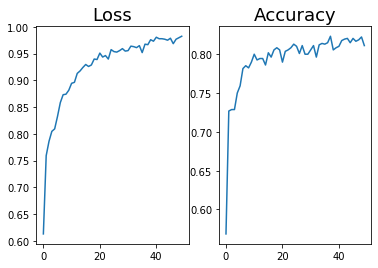

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  500, lr is 0.0001: 0.8083333333333333


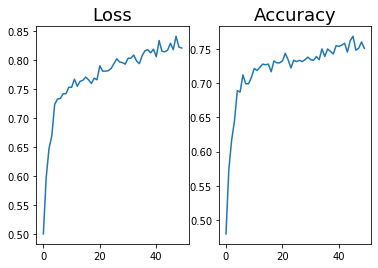

Accuracy of EEG model with  leakyrelu, batch size is   36, epochs is  500, lr is  1e-05: 0.7611111111111111


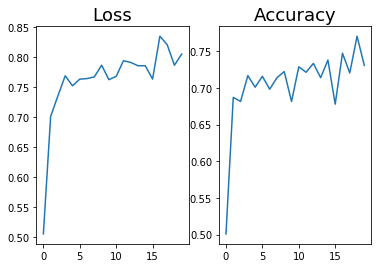

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  200, lr is    0.1: 0.7027777777777777


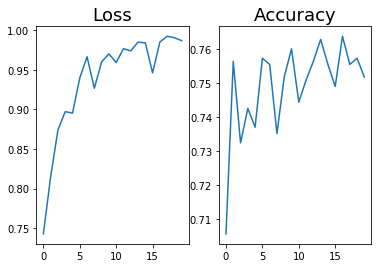

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  200, lr is   0.01: 0.7537037037037037


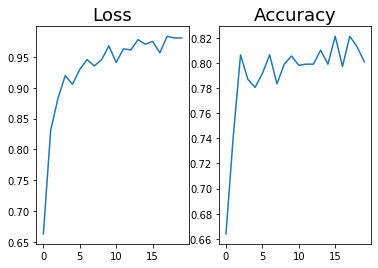

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  200, lr is  0.001: 0.7907407407407407


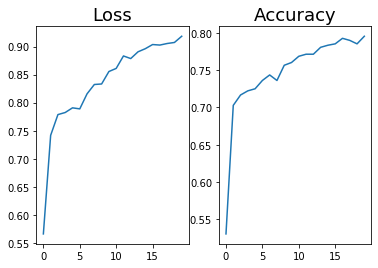

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  200, lr is 0.0001:        0.8


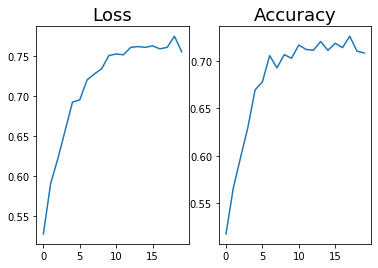

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  200, lr is  1e-05: 0.7148148148148148


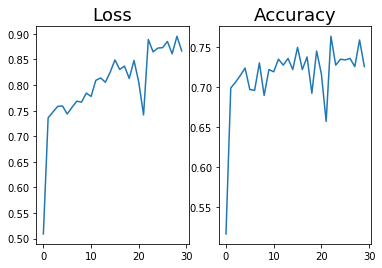

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  300, lr is    0.1: 0.7425925925925926


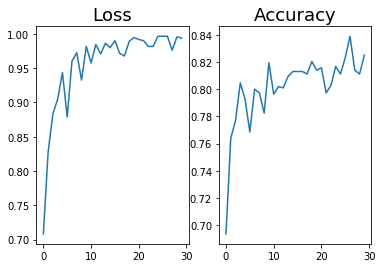

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  300, lr is   0.01: 0.8240740740740741


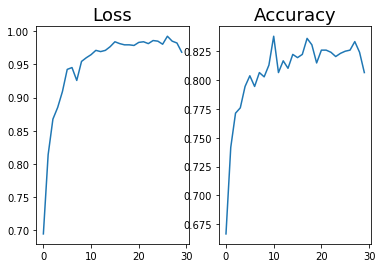

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  300, lr is  0.001: 0.8361111111111111


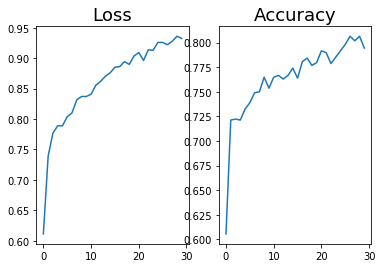

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  300, lr is 0.0001: 0.7907407407407407


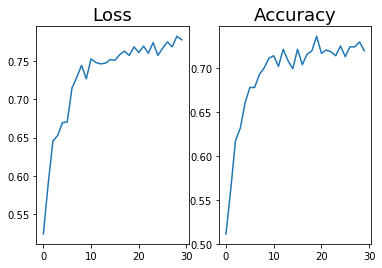

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  300, lr is  1e-05: 0.7194444444444444


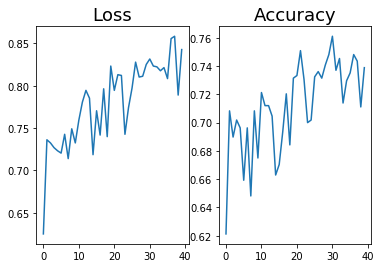

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  400, lr is    0.1:      0.725


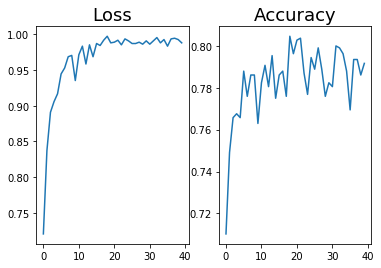

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  400, lr is   0.01: 0.7870370370370371


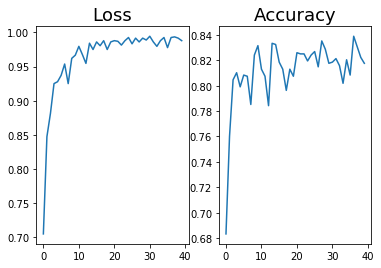

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  400, lr is  0.001: 0.8157407407407408


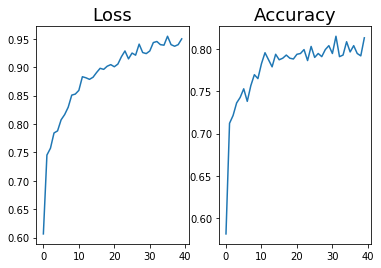

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  400, lr is 0.0001: 0.8074074074074075


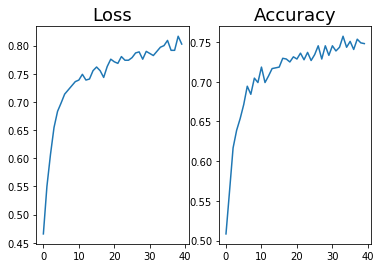

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  400, lr is  1e-05: 0.7601851851851852


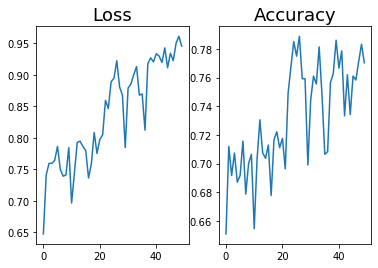

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  500, lr is    0.1: 0.7462962962962963


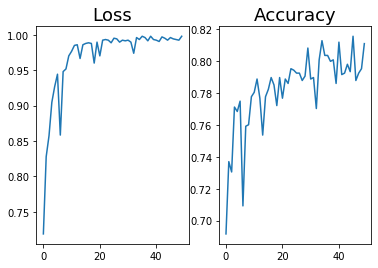

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  500, lr is   0.01: 0.8055555555555556


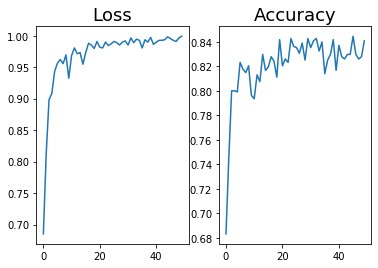

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  500, lr is  0.001: 0.8379629629629629


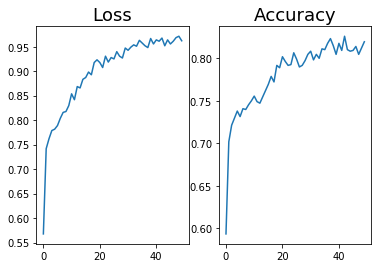

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  500, lr is 0.0001: 0.8027777777777778


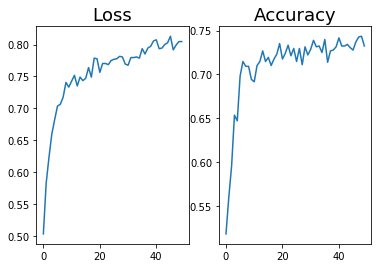

Accuracy of EEG model with  leakyrelu, batch size is   64, epochs is  500, lr is  1e-05: 0.7462962962962963


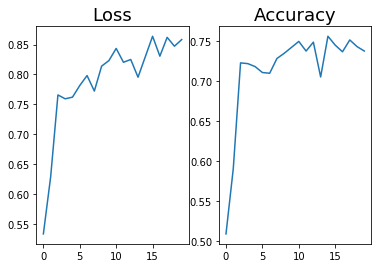

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  200, lr is    0.1: 0.7694444444444445


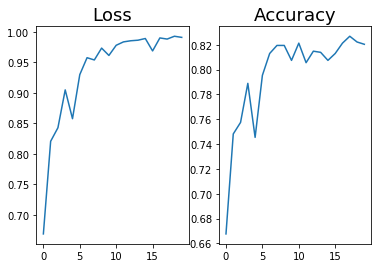

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  200, lr is   0.01: 0.8101851851851852


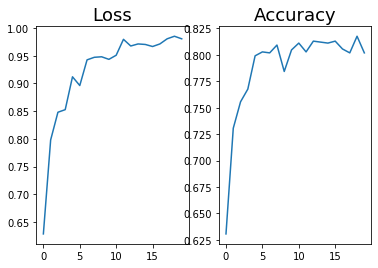

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  200, lr is  0.001: 0.8092592592592592


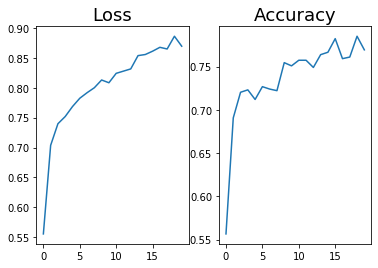

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  200, lr is 0.0001: 0.7694444444444445


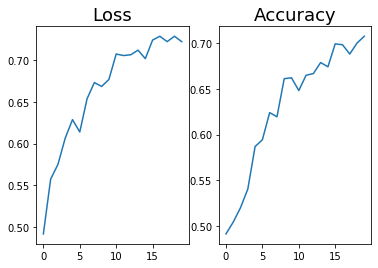

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  200, lr is  1e-05: 0.7027777777777777


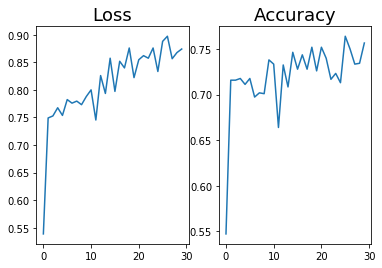

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  300, lr is    0.1: 0.7564814814814815


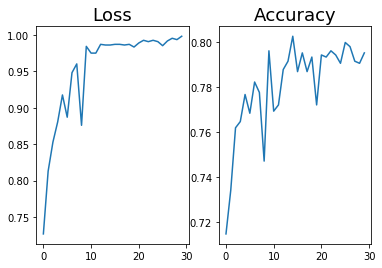

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  300, lr is   0.01: 0.7833333333333333


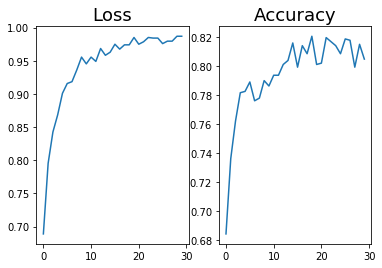

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  300, lr is  0.001: 0.8037037037037037


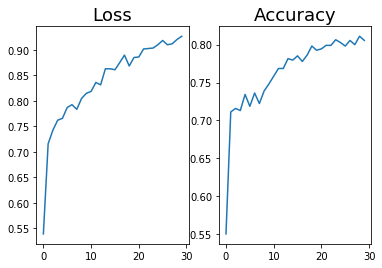

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  300, lr is 0.0001: 0.8046296296296296


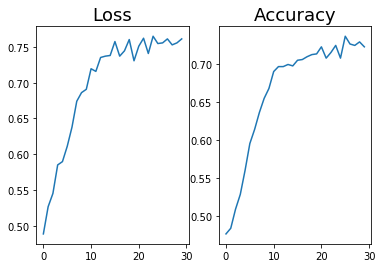

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  300, lr is  1e-05: 0.7175925925925926


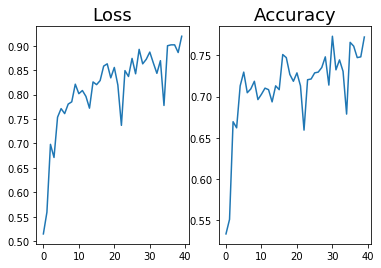

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  400, lr is    0.1:       0.75


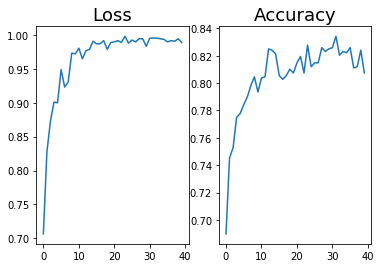

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  400, lr is   0.01: 0.8185185185185185


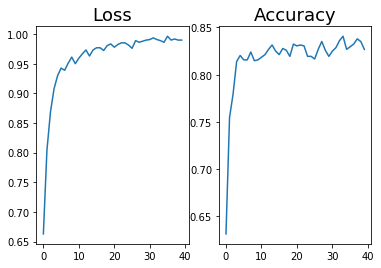

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  400, lr is  0.001: 0.8194444444444444


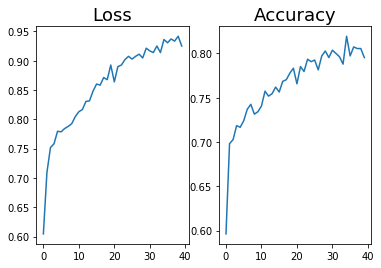

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  400, lr is 0.0001: 0.799074074074074


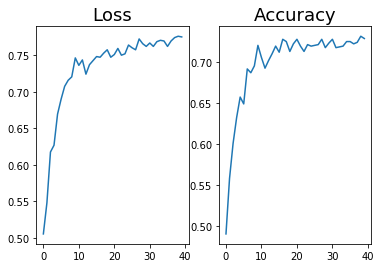

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  400, lr is  1e-05: 0.7268518518518519


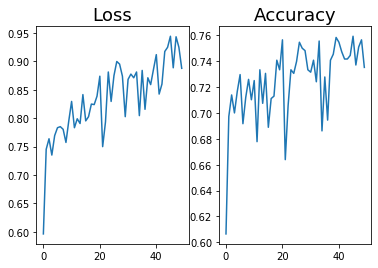

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  500, lr is    0.1: 0.7425925925925926


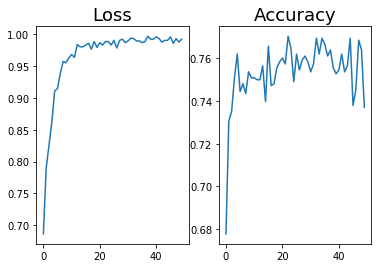

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  500, lr is   0.01: 0.7490740740740741


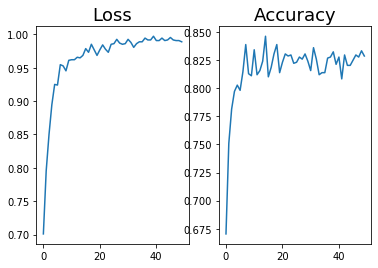

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  500, lr is  0.001: 0.8379629629629629


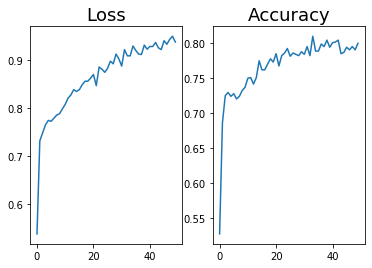

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  500, lr is 0.0001: 0.7953703703703704


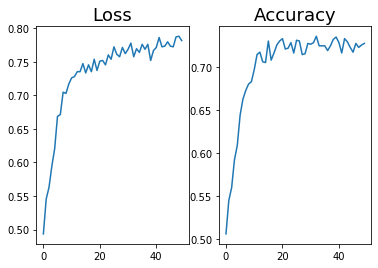

Accuracy of EEG model with  leakyrelu, batch size is  128, epochs is  500, lr is  1e-05: 0.7240740740740741


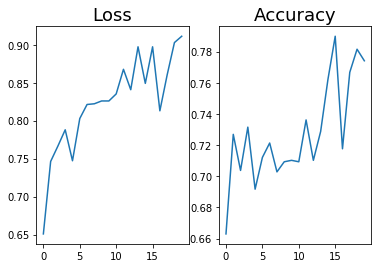

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  200, lr is    0.1: 0.7777777777777778


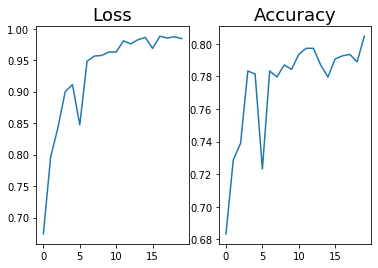

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  200, lr is   0.01: 0.7796296296296297


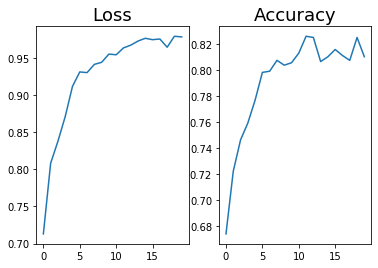

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  200, lr is  0.001:      0.825


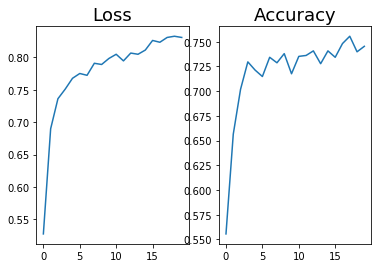

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  200, lr is 0.0001: 0.7472222222222222


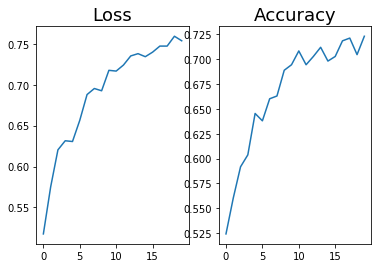

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  200, lr is  1e-05: 0.7148148148148148


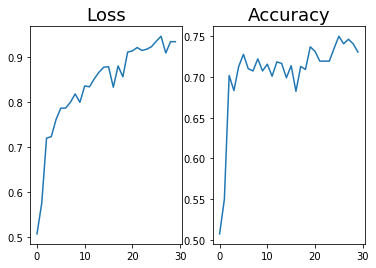

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  300, lr is    0.1: 0.7583333333333333


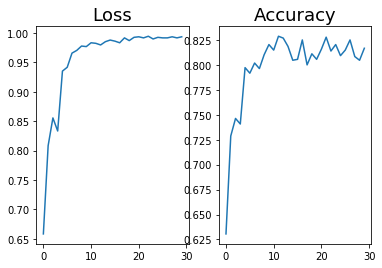

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  300, lr is   0.01: 0.7981481481481482


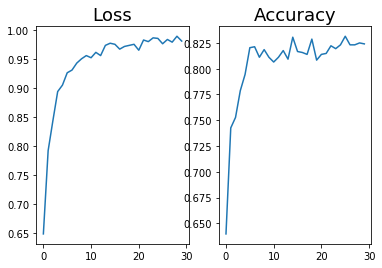

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  300, lr is  0.001: 0.8222222222222222


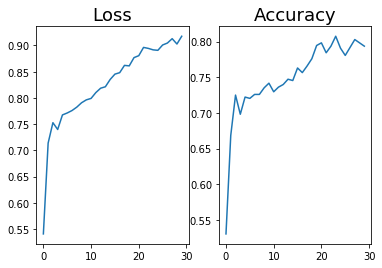

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  300, lr is 0.0001: 0.7981481481481482


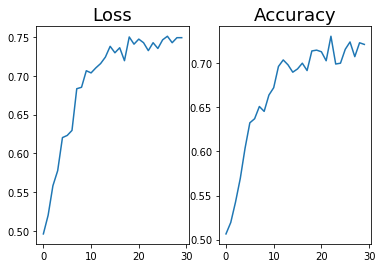

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  300, lr is  1e-05: 0.7287037037037037


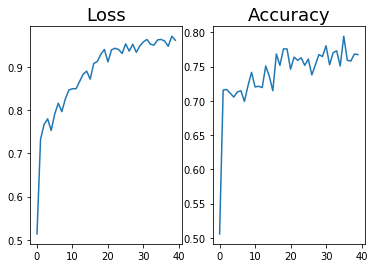

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  400, lr is    0.1: 0.7685185185185185


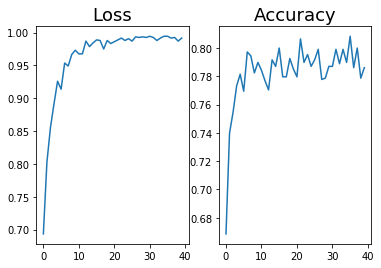

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  400, lr is   0.01: 0.7768518518518519


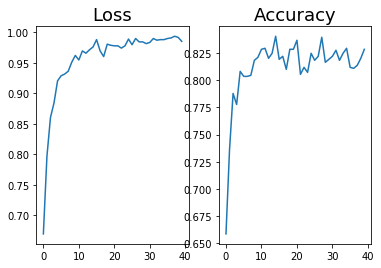

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  400, lr is  0.001: 0.8194444444444444


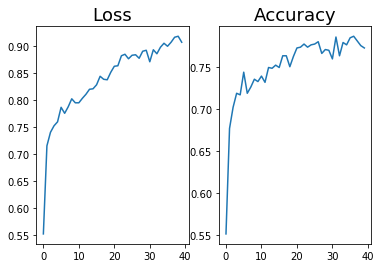

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  400, lr is 0.0001: 0.7814814814814814


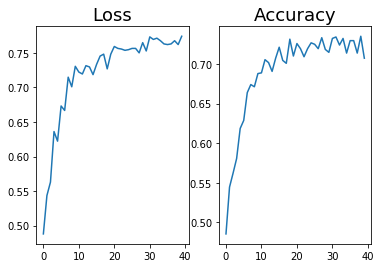

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  400, lr is  1e-05: 0.7287037037037037


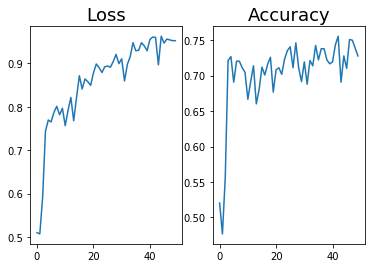

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  500, lr is    0.1: 0.7416666666666667


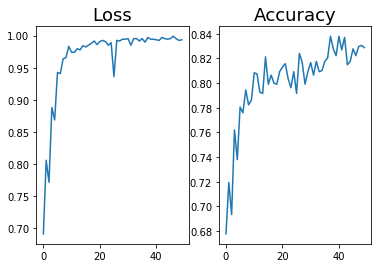

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  500, lr is   0.01: 0.8324074074074074


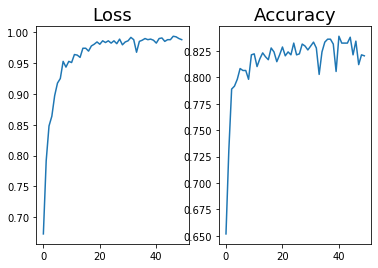

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  500, lr is  0.001: 0.8305555555555556


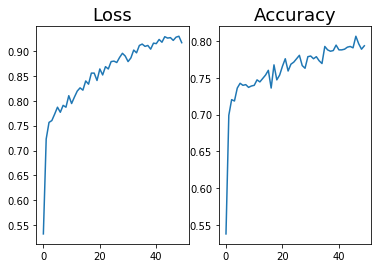

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  500, lr is 0.0001: 0.7962962962962963


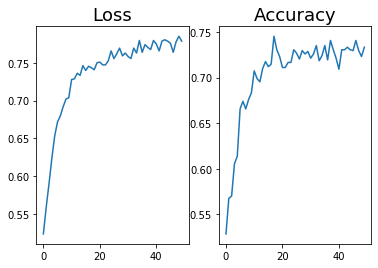

Accuracy of EEG model with  leakyrelu, batch size is  168, epochs is  500, lr is  1e-05: 0.7379629629629629
Max ccuracy is 0.8453703703703703 - EEG model with  leakyrelu, batch size is   12, epochs is  400, lr is 0.0001


In [215]:
#hyper-parameters
activation_function="leakyrelu"
batch_sizes = [12, 36, 64, 128, 168] # 64
epochss = [200, 300, 400, 500] # 300
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] # 1e-2

maxdict = {"acc":0.0, "epochs":0, "batch_size":0, "learning_rate":0}

for batch_size in batch_sizes:
    for epochs in epochss:
        for learning_rate in learning_rates:

            # creare dataloaders
            trainloader = DataLoader(trainset, batch_size=batch_size)
            testloader = DataLoader(testset, batch_size=batch_size)

            # model init
            eegmodel = EGGModel(activation_function=activation_function)
            eegmodel = eegmodel.to(device)
            eegmodel.double()

            # set optimizer, loss function
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(eegmodel.parameters(), lr=learning_rate)

            # record train accuract and test accuracy
            train_acc_list = []
            test_acc_list = []

            for epoch in range(epochs):
                running_loss = 0.0

                for data, label in trainloader:
                    # set parameter gradient into zero
                    optimizer.zero_grad()

                    # forward pass
                    output = eegmodel.forward(data)

                    # backward
                    loss = criterion(output, label)
                    loss.backward()
                    optimizer.step()

                    # record the loss
                    running_loss += loss.item()

                if epoch%10 == 0:
                    _, acc = get_predict(eegmodel, trainloader)
                    train_acc_list.append(acc)
                    _, acc = get_predict(eegmodel, testloader)
                    test_acc_list.append(acc)
        #             print ("Epoch: %s, loss: %s, accuracy: %s"%(epoch, running_loss, acc))

            # show train result
            show_result(train_acc_list, test_acc_list)

            # test 
            _, acc = get_predict(eegmodel, testloader)
            print ("Accuracy of EEG model with %10s, batch size is %4s, epochs is %4s, lr is %6s: %10s"
                   %(activation_function, batch_size, epochs, learning_rate, acc))
            # record best hyper-parameters
            if acc > maxdict["acc"]:
                maxdict["acc"] = acc
                maxdict["batch_size"] = batch_size
                maxdict["epochs"] = epochs
                maxdict["learning_rate"] = learning_rate
                
print ("Max ccuracy is %10s - EEG model with %10s, batch size is %4s, epochs is %4s, lr is %6s"
                   %(maxdict["acc"], activation_function, maxdict["batch_size"], maxdict["epochs"], maxdict["learning_rate"]))

### DeepConvNet

In [128]:
class DeepConvModel(nn.Module):
    def __init__(self, activation_function="relu"):
        # choose activation
        assert activation_function == "relu" or activation_function == "elu" or activation_function == "leakyrelu"
        self.activation = activation_function
        activation_dict = {"relu": nn.ReLU(), 
                           "elu": nn.ELU(alpha=1.0), 
                           "leakyrelu": nn.LeakyReLU(negative_slope=0.01)
                          }
        
        # init conv
        super(DeepConvModel, self).__init__()
        self.firstConv = nn.Sequential(
                            nn.Conv2d(1, 25, kernel_size=(1, 5)),
                            nn.Conv2d(25, 25, kernel_size=(2, 1)),
                            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
                            activation_dict[activation_function],
                            nn.MaxPool2d(kernel_size=(1, 2)),
                            nn.Dropout(p=0.5)
                        )
        self.secondConv = nn.Sequential(
                                nn.Conv2d(25, 50, kernel_size=(1, 5)),
                                nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
                                activation_dict[activation_function],
                                nn.MaxPool2d(kernel_size=(1, 2)),
                                nn.Dropout(p=0.5)
                            )
        self.thirdConv = nn.Sequential(
                                nn.Conv2d(50, 100, kernel_size=(1, 5)),
                                nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
                                activation_dict[activation_function],
                                nn.MaxPool2d(kernel_size=(1, 2)),
                                nn.Dropout(p=0.5)
                            )
        self.fourthConv = nn.Sequential(
                                nn.Conv2d(100,200, kernel_size=(1, 5)),
                                nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
                                activation_dict[activation_function],
                                nn.MaxPool2d(kernel_size=(1, 2)),
                                nn.Dropout(p=0.5)
                            )
        self.classify = nn.Sequential(
                            nn.Linear(in_features=8600, out_features=2, bias=True)
                        )


    def forward(self, x):
        x = self.firstConv(x)
        x = self.secondConv(x)
        x = self.thirdConv(x)
        x = self.fourthConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x
    
    def train(self, batch_size=64, epochs=300, lr=0.001):
        batch_size = batch_size
        epochs = epochs
        lr = lr
        
        # creare dataloaders
        trainloader = DataLoader(trainset, batch_size=batch_size)
        testloader = DataLoader(testset, batch_size=batch_size)
        
        # set optimizer, loss function
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # record loss and train accuracy
        train_acc = []
        test_acc = []

        for epoch in range(epochs):
            running_loss = 0.0

            for data, label in trainloader:
                # set parameter gradient into zero
                optimizer.zero_grad()

                # forward pass
                output = self.forward(data)

                # backward
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()

                # record the loss
                running_loss += loss.item()

            # record accuracy for each epochs
            _, train = get_predict(self, trainloader)
            train_acc.append(train)
            _, test = get_predict(self, testloader)
            test_acc.append(test)

            # print accuracy every 10 epochs
            if epoch % 10 == 0:
                print ("Epoch: %s, train accuracy: %s, test accuract: %s"%(epoch, train, test))
        
        # test 
        print ("Accuracy of DeepConvNet model with %s: %10s"%(self.activation, test_acc[-1]))
        
        return train_acc, test_acc

In [42]:
deepmodel = DeepConvModel(activation_function="relu")
print(deepmodel) 

DeepConvModel(
  (firstConv): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (secondConv): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (thirdConv): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, 

#### DeepConv ReLU

Epoch: 0, train accuracy: 0.5416666666666666, test accuract: 0.5277777777777778
Epoch: 10, train accuracy: 0.7435185185185185, test accuract: 0.6990740740740741
Epoch: 20, train accuracy: 0.7944444444444444, test accuract: 0.7453703703703703
Epoch: 30, train accuracy: 0.8018518518518518, test accuract: 0.7462962962962963
Epoch: 40, train accuracy: 0.8277777777777777, test accuract: 0.7472222222222222
Epoch: 50, train accuracy: 0.8157407407407408, test accuract: 0.725925925925926
Epoch: 60, train accuracy: 0.8398148148148148, test accuract: 0.7425925925925926
Epoch: 70, train accuracy: 0.8666666666666667, test accuract: 0.7555555555555555
Epoch: 80, train accuracy: 0.8648148148148148, test accuract: 0.7518518518518519
Epoch: 90, train accuracy: 0.8944444444444445, test accuract: 0.7768518518518519
Epoch: 100, train accuracy: 0.8935185185185185, test accuract: 0.7759259259259259
Epoch: 110, train accuracy: 0.8981481481481481, test accuract: 0.7564814814814815
Epoch: 120, train accuracy: 

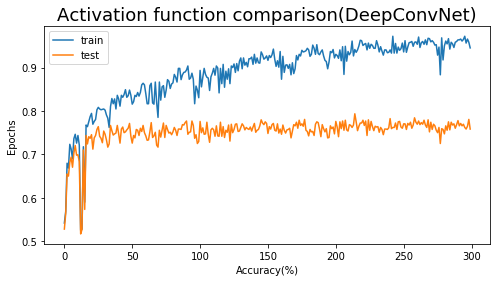

In [100]:
# model init
deepmodel = DeepConvModel(activation_function="relu")
deepmodel = deepmodel.to(device)
deepmodel.double()
deep_relu_train_acc, deep_relu_test_acc = deepmodel.train(batch_size=64, epochs=300, lr=0.001)

# show train and test result
show_one_result([deep_relu_train_acc, deep_relu_test_acc], model="DeepConvNet")

#### DeepConv Leaky ReLU

Epoch: 0, train accuracy: 0.5898148148148148, test accuract: 0.5546296296296296
Epoch: 10, train accuracy: 0.7444444444444445, test accuract: 0.6833333333333333
Epoch: 20, train accuracy: 0.7518518518518519, test accuract: 0.7194444444444444
Epoch: 30, train accuracy: 0.7731481481481481, test accuract: 0.7203703703703703
Epoch: 40, train accuracy: 0.7888888888888889, test accuract: 0.7296296296296296
Epoch: 50, train accuracy: 0.8111111111111111, test accuract: 0.7416666666666667
Epoch: 60, train accuracy: 0.7546296296296297, test accuract: 0.7037037037037037
Epoch: 70, train accuracy: 0.8212962962962963, test accuract: 0.7583333333333333
Epoch: 80, train accuracy: 0.8342592592592593, test accuract: 0.7666666666666667
Epoch: 90, train accuracy: 0.799074074074074, test accuract: 0.7333333333333333
Epoch: 100, train accuracy: 0.8722222222222222, test accuract: 0.7574074074074074
Epoch: 110, train accuracy: 0.8638888888888889, test accuract: 0.7527777777777778
Epoch: 120, train accuracy: 

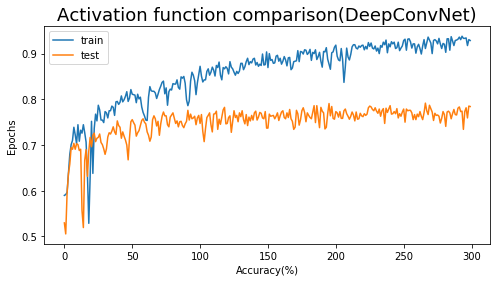

In [90]:
# model init
deepmodel = DeepConvModel(activation_function="leakyrelu")
deepmodel = deepmodel.to(device)
deepmodel.double()
deep_leakyrelu_train_acc, deep_leakyrelu_test_acc = deepmodel.train(batch_size=64, epochs=300, lr=0.0003)

# show train and test result
show_one_result([deep_leakyrelu_train_acc, deep_relu_test_acc], model="DeepConvNet")

#### DeepConv ELU

Epoch: 0, train accuracy: 0.5953703703703703, test accuract: 0.5777777777777777
Epoch: 10, train accuracy: 0.6657407407407407, test accuract: 0.6620370370370371
Epoch: 20, train accuracy: 0.7407407407407407, test accuract: 0.7129629629629629
Epoch: 30, train accuracy: 0.7638888888888888, test accuract: 0.7083333333333334
Epoch: 40, train accuracy: 0.8194444444444444, test accuract: 0.7342592592592593
Epoch: 50, train accuracy: 0.8111111111111111, test accuract: 0.7472222222222222
Epoch: 60, train accuracy: 0.8175925925925925, test accuract: 0.737037037037037
Epoch: 70, train accuracy: 0.8416666666666667, test accuract: 0.7435185185185185
Epoch: 80, train accuracy: 0.8379629629629629, test accuract: 0.7611111111111111
Epoch: 90, train accuracy: 0.8583333333333333, test accuract: 0.7490740740740741
Epoch: 100, train accuracy: 0.8583333333333333, test accuract: 0.7416666666666667
Epoch: 110, train accuracy: 0.8592592592592593, test accuract: 0.7490740740740741
Epoch: 120, train accuracy: 

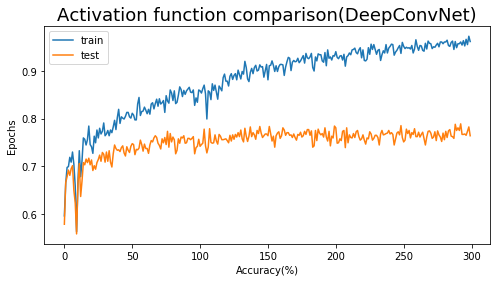

In [91]:
# model init
deepmodel = DeepConvModel(activation_function="elu")
deepmodel = deepmodel.to(device)
deepmodel.double()
deep_elu_train_acc, deep_elu_test_acc = deepmodel.train(batch_size=64, epochs=300, lr=0.0003)

# show train and test result
show_one_result([deep_elu_train_acc, deep_elu_test_acc], model="DeepConvNet")

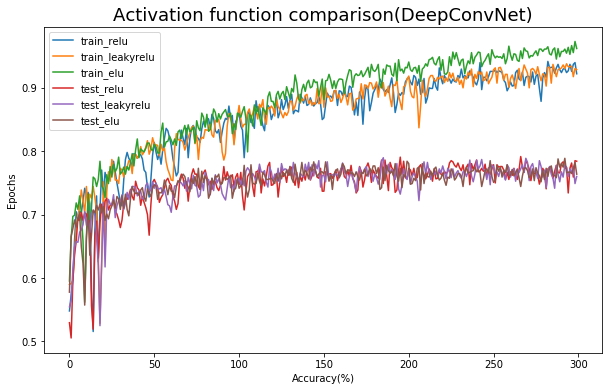

In [92]:
# show train and test result
accuracy = [deep_relu_train_acc, deep_leakyrelu_train_acc, deep_elu_train_acc, 
         deep_relu_test_acc, deep_leakyrelu_test_acc, deep_elu_test_acc]
show_result(accuracy, model="DeepConvNet")